In [27]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use("_classic_test_patch")

from collections import OrderedDict

from typing import Tuple, Optional, Dict


import numpy as np
import shapely
import shapely.affinity
from scipy.constants import epsilon_0, speed_of_light
from shapely.ops import clip_by_rect
from skfem import Basis, ElementTriP0
from skfem.io.meshio import from_meshio

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.visualization import plot_domains


from shapely.geometry import box
from tqdm import tqdm

from dataclasses import dataclass

## SiN refractive index data

Data from cornerstone (https://www.cornerstone.sotonfab.co.uk/design-rules/) for MPW no. 11.

In [4]:
# SiN refractive index data from cornerstone.
SiN_data = pd.read_csv("CORNERSTONE-SiN-index-Data.csv")
print(SiN_data.head())


# Get refractive index at wavelength 1550 nm (or closest available)
idx_1550 = (SiN_data['Wavelength (nm)'] - 1550).abs().idxmin()
SIN_INDEX_1550 = SiN_data.loc[idx_1550, 'n, Si3N4']
SIO2_INDEX_1550 = 1.444  # Refractive index of SiO2 at 1550 nm 
print(f"Refractive index at 1550 nm: {SIN_INDEX_1550}")

   Wavelength (nm)  n, Si3N4
0       192.181824  2.661700
1       193.777939  2.648604
2       195.374100  2.635457
3       196.970306  2.622259
4       198.566559  2.609011
Refractive index at 1550 nm: 1.990438


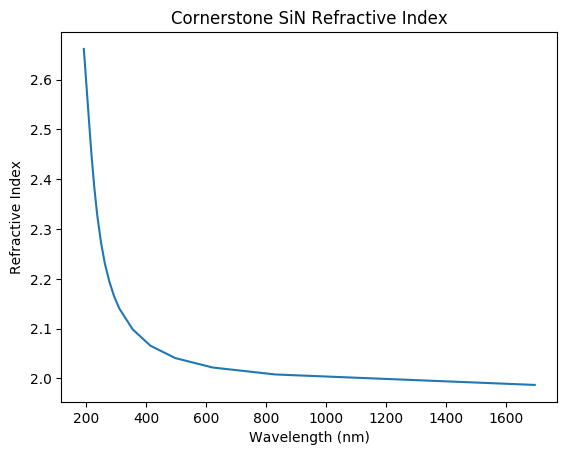

In [5]:
#PLot the refractive index data
plt.plot(SiN_data['Wavelength (nm)'], SiN_data['n, Si3N4'], label='Refractive Index')
plt.title('Cornerstone SiN Refractive Index')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Refractive Index')
plt.show()

## Basic Mode Analysis

Define the waveguide mode and create mesh.

/tmp/ipykernel_10462/2291181187.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


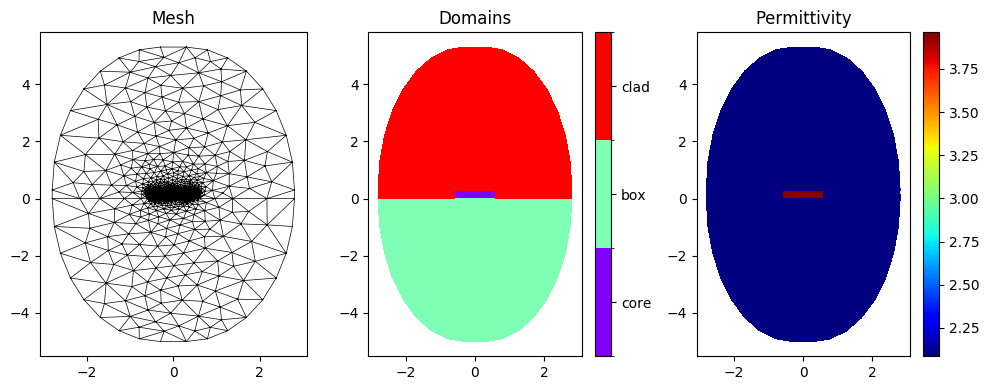

In [6]:
#generate a simple waveguide mesh
wg_width = 1.2  # um
wg_thickness = 0.3  # um

# Create the core and clad polygons

core = shapely.geometry.box(-wg_width / 2, 0, +wg_width / 2, wg_thickness)
env = shapely.affinity.scale(core.buffer(5, resolution=8), xfact=0.5)

polygons = OrderedDict(
    core=core,
    box=clip_by_rect(env, -np.inf, -np.inf, np.inf, 0),
    clad=clip_by_rect(env, -np.inf, 0, np.inf, np.inf),
)

resolutions = dict(core={"resolution": 0.03, "distance": 0.5})

# Create the mesh

mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=10))

# Permittivity calculation
# Define the permittivity for each subdomain
# Using the refractive indices defined earlier

basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
for subdomain, n in {"core": SIN_INDEX_1550, "box": SIO2_INDEX_1550, "clad": SIO2_INDEX_1550}.items():
    epsilon[basis0.get_dofs(elements=subdomain)] = n**2



# Plotting the mesh and permittivity
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
mesh.draw(ax=axs[0])
axs[0].set_title("Mesh")
plot_domains(mesh, ax=axs[1])
axs[1].set_title("Domains")
plt.tight_layout()
axs[2].set_title("Permittivity")
basis0.plot(epsilon, colorbar=True, ax=axs[2])
fig.tight_layout()
fig.show()



As an exampple we can plot the first order mode for each axis.

Effective refractive index: 1.5941+0.0000j


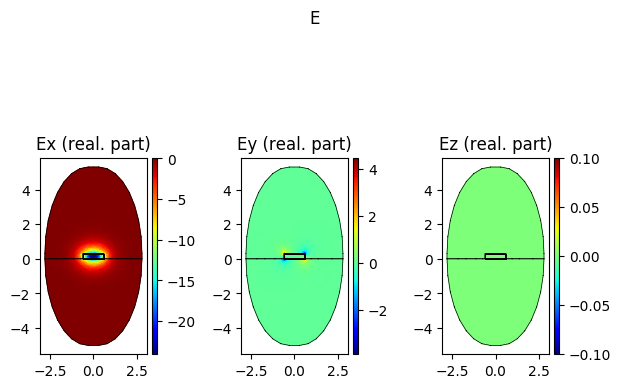

In [8]:
wavelength = 1.55

modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=1, order=2)
for mode in modes:
    print(f"Effective refractive index: {mode.n_eff:.4f}")
    mode.show("E", part="real", colorbar=True)

And plot the field intensity.

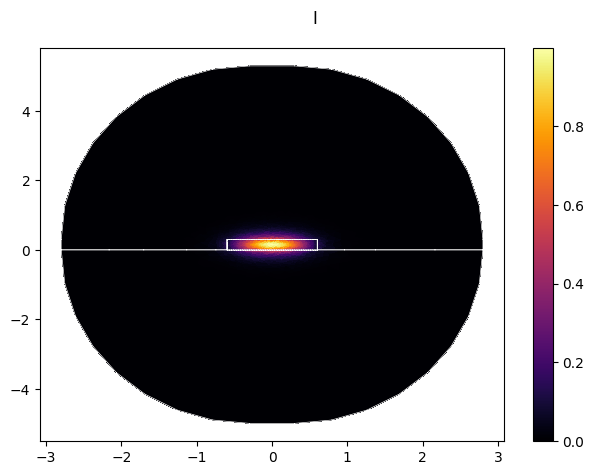

In [9]:
modes[0].show("I", colorbar=True)

## TE Polarisation Fraction - Waveguide Width.

Plot the effective index as a function of the waveguide with 

In [ ]:
def get_modes(
    wavelength: float,
    wg_thickness: float = 0.3,
    num_modes: int = 8,
    widths: np.ndarray = np.linspace(0.5, 3.5, 100)
) -> tuple:
    all_neffs = np.zeros((widths.shape[0], num_modes))
    all_te_fracs = np.zeros((widths.shape[0], num_modes))

    for i, width in enumerate(tqdm(widths)):
        core = shapely.geometry.box(-width / 2, 0, width / 2, wg_thickness)
        polygons = OrderedDict(
            core=core,
            box=clip_by_rect(core.buffer(1.0, resolution=4), -np.inf, -np.inf, np.inf, 0),
            clad=clip_by_rect(core.buffer(1.0, resolution=4), -np.inf, 0, np.inf, np.inf),
        )
        resolutions = {"core": {"resolution": 0.1, "distance": 1}}
        mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.6))
        basis0 = Basis(mesh, ElementTriP0())
        epsilon = basis0.zeros(dtype=complex)
        for subdomain, n in {"core": SIN_INDEX_1550, "box": SIO2_INDEX_1550, "clad": SIO2_INDEX_1550}.items():
            epsilon[basis0.get_dofs(elements=subdomain)] = n**2
        modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=num_modes)
        all_neffs[i] = np.real([mode.n_eff for mode in modes])
        all_te_fracs[i] = [mode.te_fraction for mode in modes]

    return all_neffs, all_te_fracs


In [16]:
all_neffs, all_te_fracs = get_modes(1.55, 0.3, 8)

100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


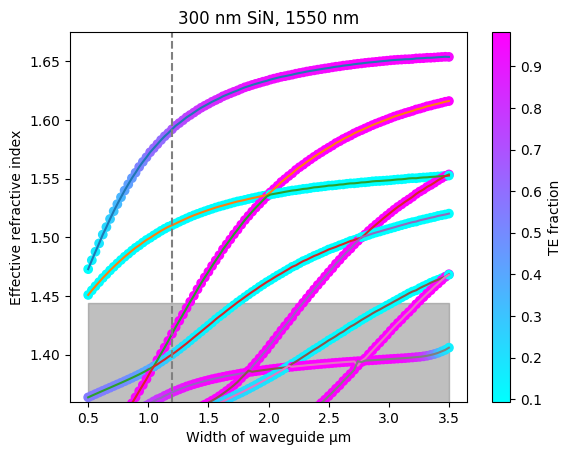

In [ ]:
all_neffs = np.real(all_neffs)
plt.xlabel("Width of waveguide µm")
plt.ylabel("Effective refractive index")
plt.title("300 nm SiN, 1550 nm")
plt.fill_between(widths, 1.444, alpha=0.8, color="gray")
plt.ylim(1.36, np.max(all_neffs) + 0.1 * (np.max(all_neffs) - 1.444))
for lams, te_fracs in zip(all_neffs.T, all_te_fracs.T):
    plt.plot(widths, lams)
    plt.scatter(widths, lams, c=te_fracs, cmap="cool")
plt.colorbar().set_label("TE fraction")
plt.axvline(1.2, color="gray", linestyle="--", label="current core width")
plt.show()

In [21]:
all_neffs_o, all_te_fracs_o = get_modes(1.31, 0.3, 8)

100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


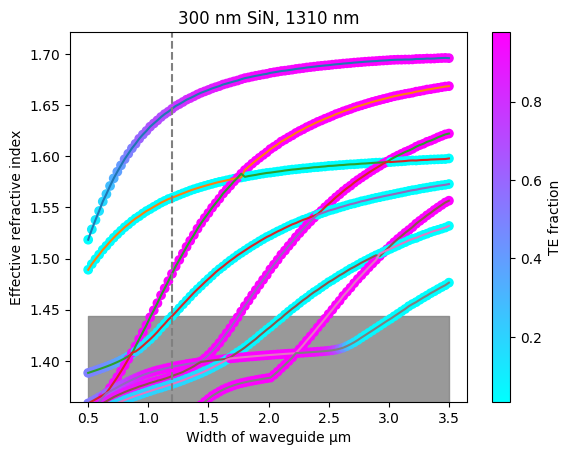

In [22]:
all_neffs = np.real(all_neffs)
plt.xlabel("Width of waveguide µm")
plt.ylabel("Effective refractive index")
plt.title("300 nm SiN, 1310 nm")
plt.fill_between(widths, 1.444, alpha=0.8, color="gray")
plt.ylim(1.36, np.max(all_neffs_o) + 0.1 * (np.max(all_neffs_o) - 1.444))
for lams, te_fracs in zip(all_neffs_o.T, all_te_fracs_o.T):
    plt.plot(widths, lams)
    plt.scatter(widths, lams, c=te_fracs, cmap="cool")
plt.colorbar().set_label("TE fraction")
plt.axvline(1.2, color="gray", linestyle="--", label="current core width")
plt.show()
